1. High affinity, Lipinski rule-of-five and PAINS filter

In [31]:
from rdkit.Chem import Descriptors, Lipinski, FilterCatalog, rdMolDescriptors
from rdkit.Chem.FilterCatalog import FilterCatalogParams
import pandas as pd
from tqdm import tqdm
from rdkit import Chem

# 1. 定义Lipinski规则过滤器
def passes_lipinski(mol):
    """检查分子是否符合Lipinski规则"""
    mw = Descriptors.MolWt(mol)  # 分子量
    logp = Descriptors.MolLogP(mol)  # LogP
    hbd = Lipinski.NumHDonors(mol)  # 氢键供体
    hba = Lipinski.NumHAcceptors(mol)  # 氢键受体
    RotBonds = rdMolDescriptors.CalcNumRotatableBonds(mol) # 可旋转键

    # Lipinski五规则
    return (mw <= 500 and
            logp <= 5 and
            hbd <= 5 and
            hba <= 10 and
            RotBonds <= 10)


# 2. 定义PAINS过滤器
def initialize_pains_filter():
    """初始化PAINS过滤器"""
    params = FilterCatalogParams()
    params.AddCatalog(FilterCatalogParams.FilterCatalogs.PAINS)
    catalog = FilterCatalog.FilterCatalog(params)
    return catalog


# 3. 主处理函数
def filter_molecules(input_file, output_file):
    """执行过滤流程"""
    # 读取数据并选择所需的列
    df = pd.read_csv(input_file, sep='\t', header=0, usecols=[0, 1, 5], names=['zinc_id', 'SMILES', 'affinity'])
    print(f"原始分子数: {len(df)}")

    df_sorted = df.sort_values(by='affinity', ascending=False)
    df_high = df_sorted[df_sorted['affinity'] > 6.5]
    print(f"affinity大于6.5的分子数: {len(df_high)}")
    
    pains_catalog = initialize_pains_filter()

    # 处理分子
    results = []
    for _, row in tqdm(df_high.iterrows(), total=len(df_high), desc="Processing Molecules"):
        zinc_id = row['zinc_id']
        smi = row['SMILES']
        affinity = row['affinity']
        try:
            mol = Chem.MolFromSmiles(smi)
            if not mol:
                continue

            # 检查Lipinski规则
            lipinski_ok = passes_lipinski(mol)

            # 检查PAINS
            pains_match = pains_catalog.HasMatch(mol)
            pains_ok = not pains_match  # PAINS匹配表示有问题

            if lipinski_ok and pains_ok:
                results.append({'zinc_id': zinc_id,'SMILES': smi, 'affinity': affinity})

        except Exception as e:
            print(f"Error processing SMILES: {smi}\n{str(e)}")

    # 保存结果
    filtered_df = pd.DataFrame(results)
    filtered_df.to_csv(output_file, index=False)
    print(f"\n最终保留分子数: {len(filtered_df)}")
    print(f"过滤后文件已保存至: {output_file}")


if __name__ == "__main__":
    # 配置参数
    config = {
        "input_file": "./MultiGeoDTA/output/zinc/prediction.tsv",
        "output_file": "./MultiGeoDTA/output/zinc/filtered_molecules_1.csv",
    }

    filter_molecules(config["input_file"], config["output_file"])


原始分子数: 594302
affinity大于6.5的分子数: 3631


Processing Molecules: 100%|██████████| 3631/3631 [00:11<00:00, 322.65it/s]



最终保留分子数: 3554
过滤后文件已保存至: ./MultiGeoDTA/output/zinc/filtered_molecules_1.csv


ZINC001341460450
ZINC000749087800
ZINC000537551486
ZINC000518437019
ZINC000053754936

2. Cluster-based filter

成功读取前 3554 个SMILES


Processing SMILES: 100%|██████████| 3554/3554 [00:03<00:00, 938.10it/s]


生成 3554 个有效指纹


Calculating similarities and clustering: 100%|█████████▉| 3553/3554 [00:00<00:00, 3582.60it/s] 


得到 1330 个聚类
保存聚类结果...
选择每个聚类中affinity最高的数据...
新的数据集已保存到 ./MultiGeoDTA/output/zinc/filtered_molecules_2.csv
可视化聚类结果...


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


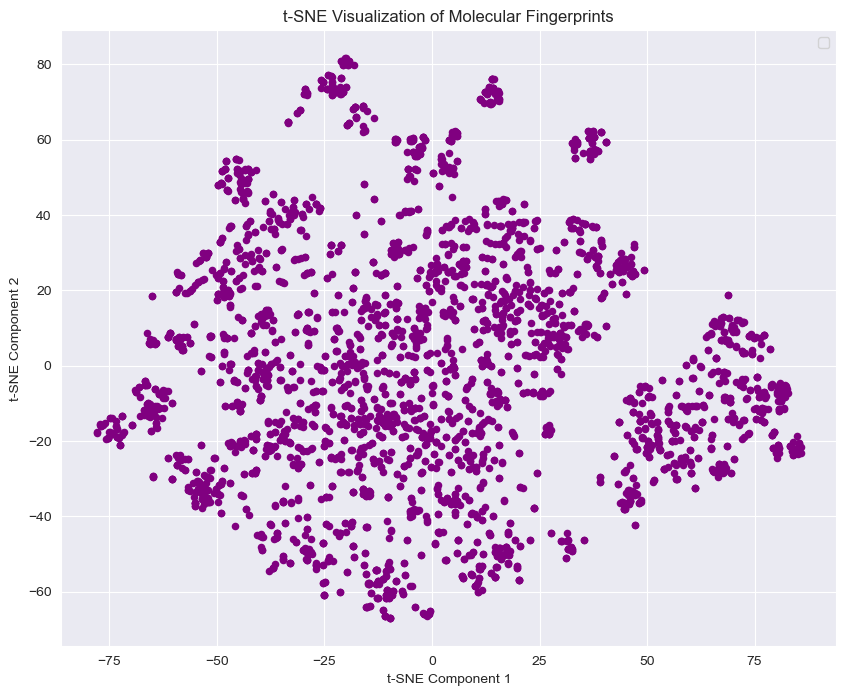

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


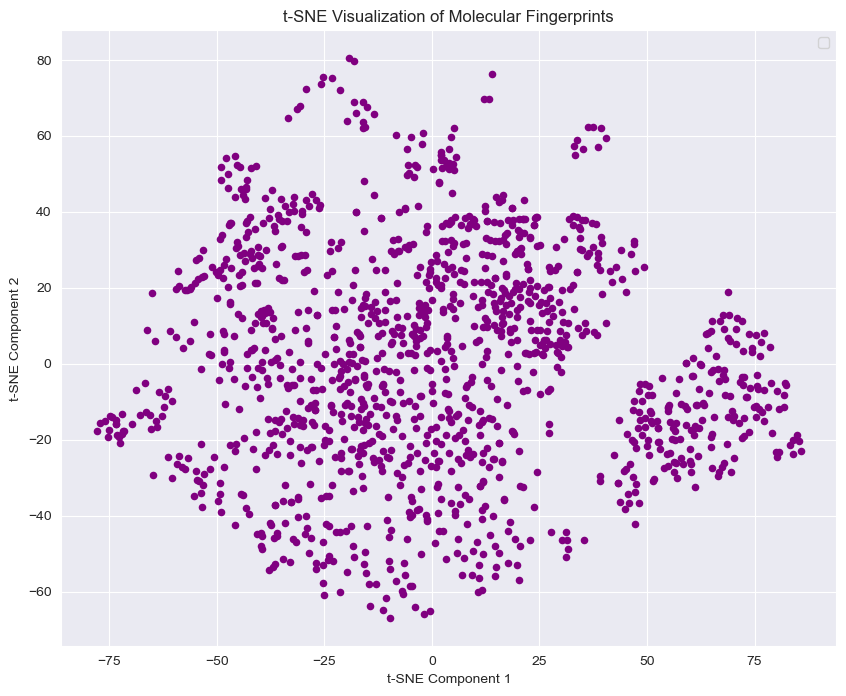

In [5]:
import pandas as pd
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, MACCSkeys
from rdkit.ML.Cluster import Butina
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE


def process_smiles(smiles_list):
    """处理SMILES生成分子指纹"""
    fps = []
    for idx, smi in tqdm(enumerate(smiles_list), total=len(smiles_list), desc="Processing SMILES"):
        mol = Chem.MolFromSmiles(smi)
        fp = MACCSkeys.GenMACCSKeys(mol)
        # fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)
        fps.append(fp)

    return fps

def cluster_molecules(fps, threshold=None):
    """执行Butina聚类"""
    nfps = len(fps)
    dists = []
    with tqdm(total=nfps, desc="Calculating similarities and clustering") as pbar:
        for i in range(1, nfps):
            sims = DataStructs.BulkTanimotoSimilarity(fps[i], fps[:i])
            dists.extend([1 - x for x in sims])
            pbar.update(1)
    cutoff = 1 - threshold
    clusters = Butina.ClusterData(dists, nfps, cutoff, isDistData=True)
    return clusters


if __name__ == "__main__":
    # 步骤1：读取数据
    df = pd.read_csv('./MultiGeoDTA/output/zinc/filtered_molecules_1.csv')
    smiles_list = df['SMILES'].tolist()
    print(f"成功读取前 {len(smiles_list)} 个SMILES")

    # 步骤2：处理分子
    fps = process_smiles(smiles_list)
    print(f"生成 {len(fps)} 个有效指纹")

    # 步骤3：执行聚类
    clusters = cluster_molecules(fps, 0.9)
    print(f"得到 {len(clusters)} 个聚类")

    # 步骤4：保存结果
    print("保存聚类结果...")
    df['ClusterID'] = -1  # 初始化聚类ID列

    for cluster_id, cluster in enumerate(clusters):
        for idx in cluster:
            df.at[idx, 'ClusterID'] = cluster_id

    # 步骤5：在每个聚类中选择affinity最高的数据
    print("选择每个聚类中affinity最高的数据...")
    top_affinity_indices = []
    for cluster_id in range(len(clusters)):
        cluster_data = df[df['ClusterID'] == cluster_id]
        if not cluster_data.empty:
            top_affinity_idx = cluster_data['affinity'].idxmax()
            top_affinity_indices.append(top_affinity_idx)

    # 创建新的数据集
    top_affinity_df = df.loc[top_affinity_indices].reset_index(drop=True)
    top_affinity_df.to_csv("./MultiGeoDTA/output/zinc/filtered_molecules_2.csv", index=False)
    print(f"新的数据集已保存到 ./MultiGeoDTA/output/zinc/filtered_molecules_2.csv")
    
    # 步骤6：可视化聚类结果
    print("可视化聚类结果...")
    fp_array = np.array([fp for fp in fps])
    tsne = TSNE(n_components=2, random_state=42)
    fp_tsne = tsne.fit_transform(fp_array)
    plt.figure(figsize=(10, 8))

    non_top_indices = [idx for idx in range(len(df)) if idx not in top_affinity_indices]
    plt.scatter(fp_tsne[:, 0], fp_tsne[:, 1], c='purple', s=30, linewidths=0)
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.title('t-SNE Visualization of Molecular Fingerprints')
    plt.legend()
    plt.savefig('./MultiGeoDTA/output/zinc/cluster_before.pdf')
    plt.show()
    
    plt.figure(figsize=(10, 8))
    plt.scatter(fp_tsne[top_affinity_indices, 0], fp_tsne[top_affinity_indices, 1], c='purple', s=30, linewidths=0)
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.title('t-SNE Visualization of Molecular Fingerprints')
    plt.legend()
    plt.savefig('./MultiGeoDTA/output/zinc/cluster_after.pdf')
    plt.show()

3. Top QED scores filter

In [33]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import QED

df = pd.read_csv('./MultiGeoDTA/output/zinc/filtered_molecules_2.csv')

def calculate_qed(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        return QED.qed(mol)
    else:
        return None

# 为 DataFrame 添加 QED 列
df['QED'] = df['SMILES'].apply(calculate_qed)
top_drug_df = df[df['QED'] > 0.6]
top_drug_df = top_drug_df.sort_values(by='affinity', ascending=False)

top_drug_df.to_csv('./MultiGeoDTA/output/zinc/filtered_molecules_3.csv', index=False)
print(f"筛选后的分子已保存到 ./MultiGeoDTA/output/zinc/filtered_molecules_3.csv，共 {len(top_drug_df)} 个分子")



筛选后的分子已保存到 ./MultiGeoDTA/output/zinc/filtered_molecules_3.csv，共 809 个分子


4. ADMET-lab filters toxic molecule

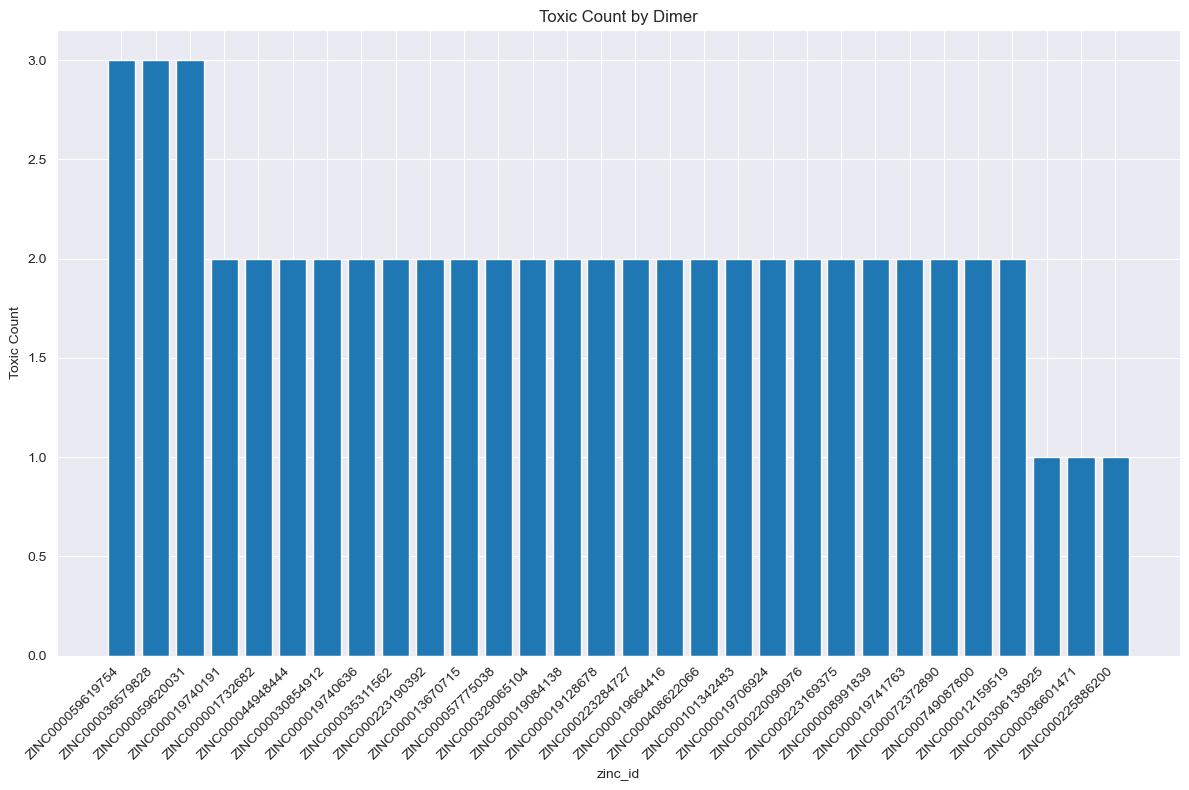


符合条件的safe_smiles数量：0
每一个safe_smiles：
save in safe_smiles.csv
save in ./MultiGeoDTA/output/zinc/toxicity_features_count.pdf
save in ./MultiGeoDTA/output/zinc/toxicity_features_distribution.pdf


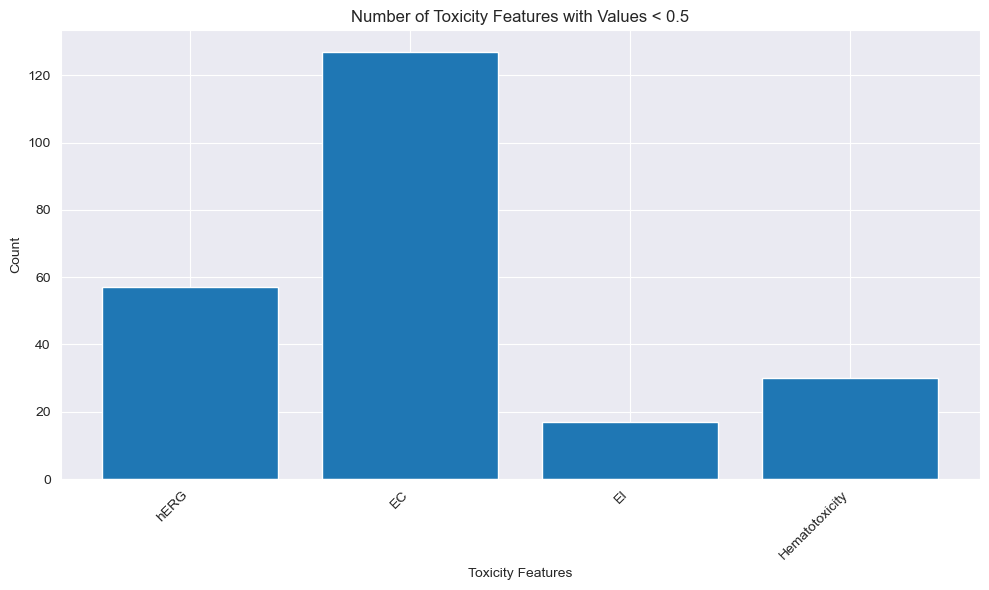

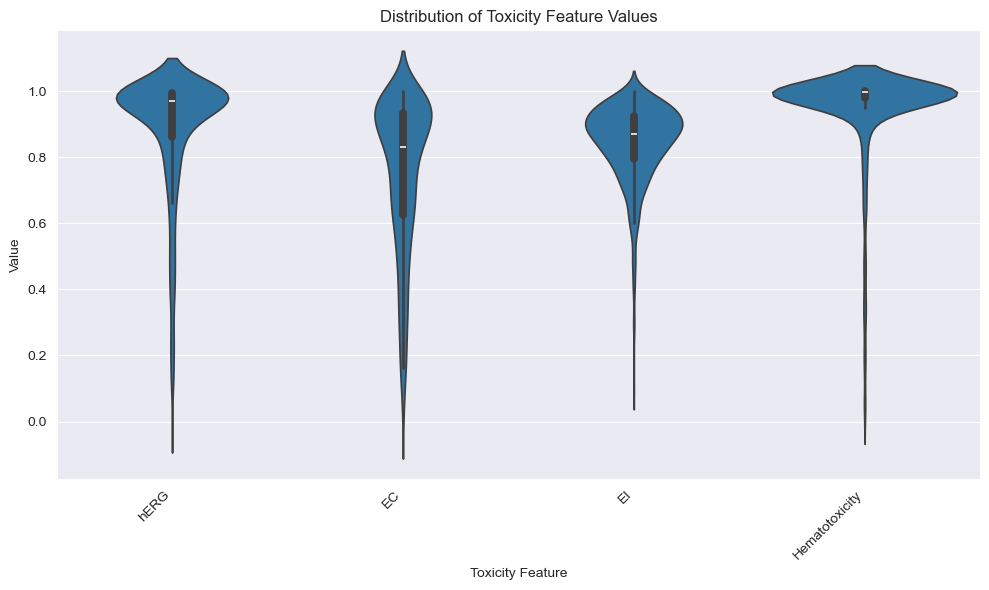

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# tox_df = pd.read_csv(
#     './MultiGeoDTA/output/zinc/Top_molecule_admetlab_analysis.csv',
#     usecols=['zinc_id', 'SMILES', 'affinity', 'hERG', 'hERG-10um', 'DILI', 'Ames', 'ROA', 'FDAMDD', 'SkinSen', 'Carcinogenicity', 'EC', 'EI', 'Respiratory', 'H-HT', 'Neurotoxicity-DI', 'Ototoxicity', 'Hematotoxicity', 'Nephrotoxicity-DI', 'Genotoxicity', 'RPMI-8226', 'A549', 'HEK293']
# )

tox_df = pd.read_csv(
    './MultiGeoDTA/output/zinc/Top_molecule_admetlab_analysis.csv',
    usecols=['zinc_id', 'SMILES', 'affinity', 'hERG', 'EC', 'EI', 'Hematotoxicity']
)

tox_df['non_toxic_count'] = tox_df.iloc[:, 3:].apply(lambda row: sum(row < 0.5), axis=1)
sorted_tox_df = tox_df.sort_values(by='non_toxic_count', ascending=False)
sorted_tox_df.to_csv('./MultiGeoDTA/output/zinc/smiles_sorted_by_toxic.csv', index=False)

plt.figure(figsize=(12, 8))
plt.bar(sorted_tox_df['zinc_id'][:30], sorted_tox_df['non_toxic_count'][:30])
plt.xlabel('zinc_id')
plt.ylabel('Toxic Count')
plt.title('Toxic Count by Dimer')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('./MultiGeoDTA/output/zinc/toxic_count_by_dimer.pdf', format='pdf')
plt.show()

safe_smiles = tox_df[tox_df.iloc[:, 3:-1].apply(lambda row: all(val < 0.5 for val in row), axis=1)]
safe_count = len(safe_smiles)
print(f"\n符合条件的safe_smiles数量：{safe_count}")
print("每一个safe_smiles：")
for smile in safe_smiles['SMILES']:
    print(smile)
safe_smiles.to_csv('./MultiGeoDTA/output/zinc/safe_smiles.csv', index=False)
print(f"save in safe_smiles.csv")

tox_count = {}
for col in tox_df.columns[3:-1]:
    count = len(tox_df[tox_df[col] < 0.5])
    tox_count[col] = count
tox_count_df = pd.DataFrame.from_dict(tox_count, orient='index', columns=['Count'])
tox_count_df = tox_count_df.sort_values(by='Count', ascending=False)
tox_count_df.to_csv('./MultiGeoDTA/output/zinc/non_tox_count.csv', index=True)

plt.figure(figsize=(10, 6))
plt.bar(tox_count.keys(), tox_count.values())
plt.xlabel('Toxicity Features')
plt.ylabel('Count')
plt.title('Number of Toxicity Features with Values < 0.5')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('./MultiGeoDTA/output/zinc/toxicity_features_count.pdf', format='pdf')

toxicity_cols = tox_df.columns[3:-1]  # 排除Dimer, smiles和toxic_count列
tox_df_long = pd.melt(tox_df, id_vars=['SMILES'], value_vars=toxicity_cols, var_name='Toxicity Feature', value_name='Value')
plt.figure(figsize=(10, 6))
sns.violinplot(x='Toxicity Feature', y='Value', data=tox_df_long)
plt.xticks(rotation=45, ha='right')
plt.title('Distribution of Toxicity Feature Values')
plt.tight_layout()
plt.savefig('./MultiGeoDTA/output/zinc/toxicity_features_distribution.pdf', format='pdf')

print("save in ./MultiGeoDTA/output/zinc/toxicity_features_count.pdf")
print("save in ./MultiGeoDTA/output/zinc/toxicity_features_distribution.pdf")